In [1]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

# Exercise 1

## Analyze how travelers expressed their feelings on Twitter

A sentiment analysis job about the problems of each major U.S. airline.
Twitter data was scraped from February of 2015 and contributors were
asked to first classify positive, negative, and neutral tweets, followed
by categorizing negative reasons (such as "late flight" or "rude service").

In [2]:
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt

# read the data and set the datetime as the index
tweets = pd.read_csv('https://github.com/sergiomora03/AdvancedTopicsAnalytics/raw/main/datasets/Tweets.zip', index_col=0)

tweets.head()

,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
tweet_id,,,,,,,,,,,,,,
570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [3]:
tweets.shape

(14640, 14)

### Proportion of tweets with each sentiment

In [4]:
tweets['airline_sentiment'].value_counts()

,count
airline_sentiment,
negative,9178
neutral,3099
positive,2363


### Proportion of tweets per airline


In [5]:
tweets['airline'].value_counts()

,count
airline,
United,3822
US Airways,2913
American,2759
Southwest,2420
Delta,2222
Virgin America,504


<Axes: xlabel='airline'>

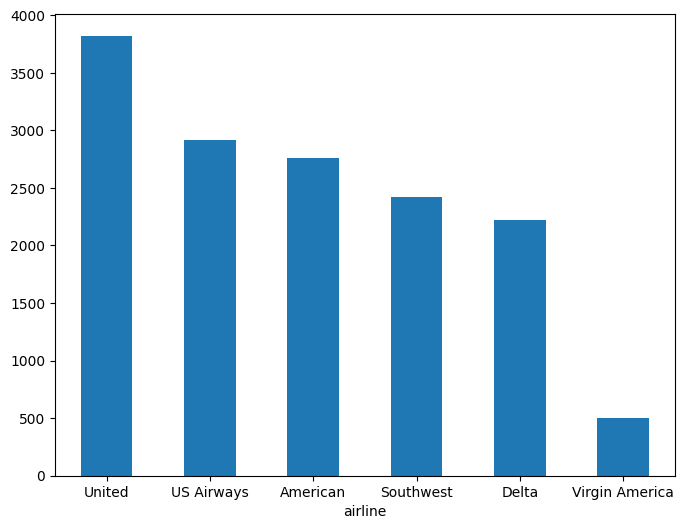

In [6]:
pd.Series(tweets["airline"]).value_counts().plot(kind = "bar",figsize=(8,6),rot = 0)

<Axes: title={'center': 'Sentiment by airline'}, xlabel='airline'>

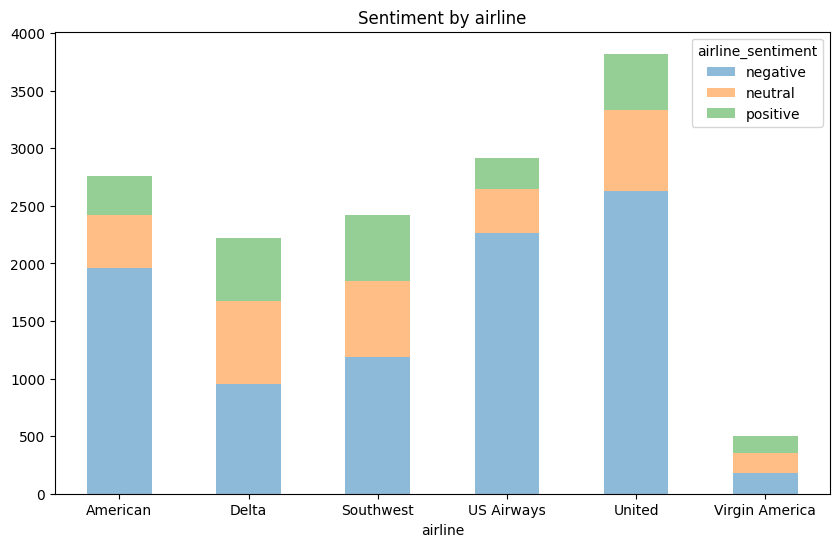

In [7]:
pd.crosstab(index = tweets["airline"],columns = tweets["airline_sentiment"]).plot(kind='bar',figsize=(10, 6),alpha=0.5,rot=0,stacked=True,title="Sentiment by airline")

Pre-Procesamiento de la data

Se realiza la limpieza de la data y definición de variable objetivo

In [8]:
import re


def limpiar_data(texto: str) -> pd.DataFrame:
    texto = texto.str.lower()
    palabras_eliminar = r'[.,!*?@#$%()\[\]=+"]'  # Limpiar puntuación
    texto = texto.str.replace(palabras_eliminar, "", regex=True)
    return texto

In [9]:
X = tweets["text"]
y = tweets["airline_sentiment"].map({"negative": -1, "neutral": 0, "positive": 1})

In [10]:
X = limpiar_data(X)

In [11]:
X

,text
tweet_id,
570306133677760513,virginamerica what dhepburn said
570301130888122368,virginamerica plus you've added commercials to...
570301083672813571,virginamerica i didn't today must mean i need ...
570301031407624196,virginamerica it's really aggressive to blast ...
570300817074462722,virginamerica and it's a really big bad thing ...
...,...
569587686496825344,americanair thank you we got on a different fl...
569587371693355008,americanair leaving over 20 minutes late fligh...
569587242672398336,americanair please bring american airlines to ...


In [12]:
y

,airline_sentiment
tweet_id,
570306133677760513,0
570301130888122368,1
570301083672813571,0
570301031407624196,-1
570300817074462722,-1
...,...
569587686496825344,1
569587371693355008,-1
569587242672398336,0


Generación de matriz de características numéricas

In [13]:
count_vect = (CountVectorizer())
# Se mantiene frecuencia para identificar tendencias

In [14]:
CountV = count_vect.fit_transform(X).toarray()
CountV.shape

(14640, 15740)

Partición de la data en entrenamiento y prueba

20% de los datos para hacer pruebas

In [15]:
x_train, x_test, y_train, y_test = (train_test_split (CountV, y, test_size=0.2, random_state=42))

Estandarización de datos

In [16]:
print(x_train.shape)
print(x_test.shape)

(11712, 15740)
(2928, 15740)


In [17]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

# Exercise 1.1

Predict the sentiment using CountVectorizer

use Random Forest classifier

In [18]:
# Crear el modelo de Random Forest
rf_model_1 = RandomForestClassifier(random_state=42, n_jobs=-1)

# Entrenar el modelo con los datos de entrenamiento
rf_model_1.fit(x_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

Training Metrics:
Accuracy: 0.9978
Precision: 0.9978
Recall: 0.9978
F1-Score: 0.9978

Testing Metrics:
Accuracy: 0.7702
Precision: 0.7635
Recall: 0.7702
F1-Score: 0.7459


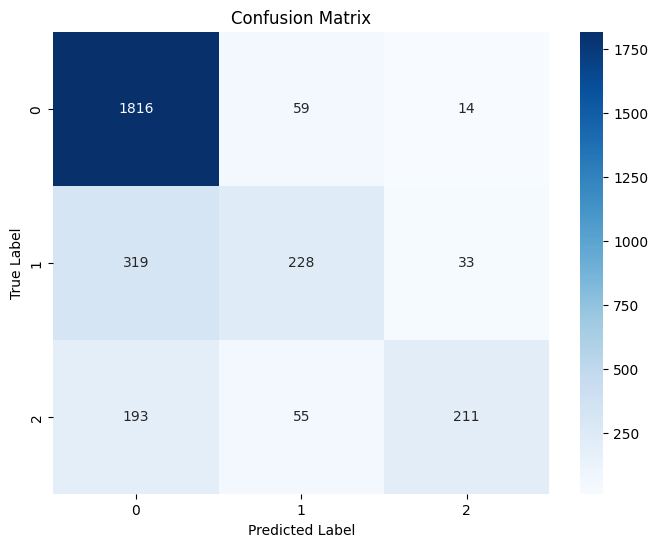

In [19]:
# Predicciones en el conjunto de entrenamiento
y_train_pred = rf_model_1.predict(x_train)

# Predicciones en el conjunto de prueba
y_test_pred = rf_model_1.predict(x_test)

# Cálculo de métricas en el conjunto de entrenamiento (Multiclase)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Cálculo de métricas en el conjunto de prueba (Multiclase)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Mostrar las métricas para el conjunto de entrenamiento
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")

# Mostrar las métricas para el conjunto de prueba
print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Graficar la matriz de confusión para el conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Exercise 1.2

Remove stopwords, then predict the sentiment using CountVectorizer.

use Random Forest classifier

In [20]:
count_vect_sw = CountVectorizer(stop_words="english")
CountV_sw = count_vect_sw.fit_transform(X).toarray()
CountV_sw.shape

(14640, 15458)

In [21]:
x_train, x_test, y_train, y_test = (train_test_split (CountV_sw, y, test_size=0.2, random_state=42))
print(x_train.shape)
print(x_test.shape)

(11712, 15458)
(2928, 15458)


In [22]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Training Metrics:
Accuracy: 0.9958
Precision: 0.9958
Recall: 0.9958
F1-Score: 0.9958

Testing Metrics:
Accuracy: 0.7715
Precision: 0.7626
Recall: 0.7715
F1-Score: 0.7651


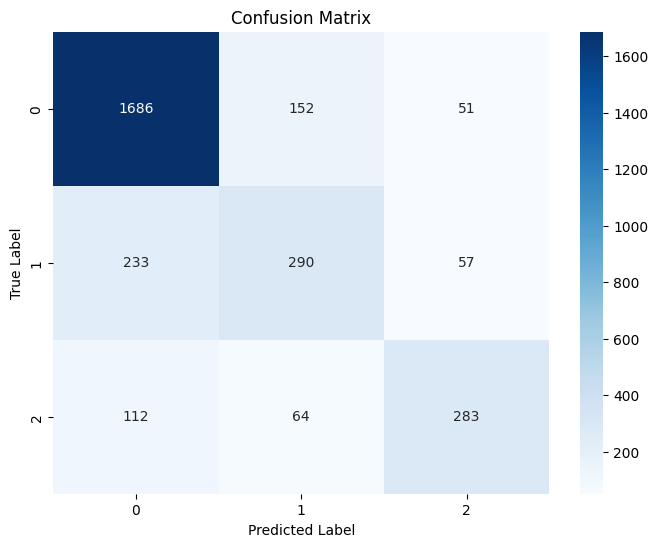

In [23]:
# Entrenar el modelo con los datos de entrenamiento
rf_model_1.fit(x_train, y_train)

# Predicciones en el conjunto de entrenamiento
y_train_pred = rf_model_1.predict(x_train)

# Predicciones en el conjunto de prueba
y_test_pred = rf_model_1.predict(x_test)

# Cálculo de métricas en el conjunto de entrenamiento (Multiclase)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Cálculo de métricas en el conjunto de prueba (Multiclase)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Mostrar las métricas para el conjunto de entrenamiento
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")

# Mostrar las métricas para el conjunto de prueba
print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Graficar la matriz de confusión para el conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Exercise 1.3

Increase n_grams size (with and without stopwords),  then predict the sentiment using CountVectorizer

use Random Forest classifier

WITHOUT STOPWORDS

In [24]:
count_vect_ngram = CountVectorizer(ngram_range=(1,3), stop_words="english")
CountV_ngram = count_vect_ngram.fit_transform(X).toarray()
CountV_ngram.shape

(14640, 202516)

In [25]:
x_train, x_test, y_train, y_test = (train_test_split (CountV_ngram, y, test_size=0.2, random_state=42))
print(x_train.shape)
print(x_test.shape)

(11712, 202516)
(2928, 202516)


In [26]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Training Metrics:
Accuracy: 0.9959
Precision: 0.9959
Recall: 0.9959
F1-Score: 0.9959

Testing Metrics:
Accuracy: 0.7667
Precision: 0.7543
Recall: 0.7667
F1-Score: 0.7549


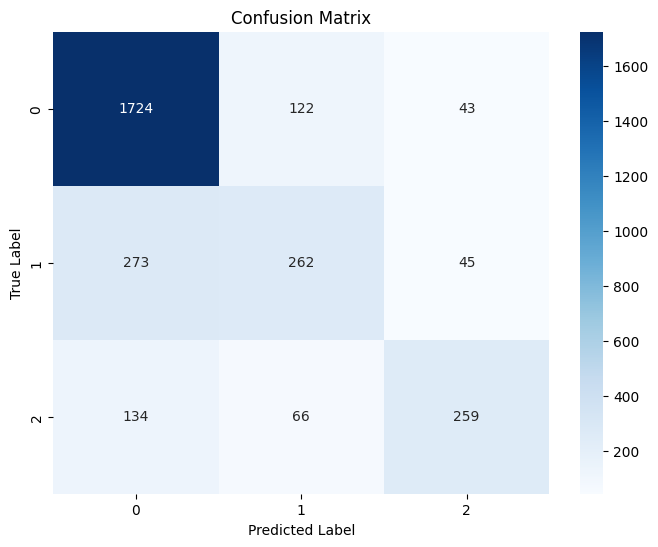

In [27]:
# Entrenar el modelo con los datos de entrenamiento
rf_model_1.fit(x_train, y_train)

# Predicciones en el conjunto de entrenamiento
y_train_pred = rf_model_1.predict(x_train)

# Predicciones en el conjunto de prueba
y_test_pred = rf_model_1.predict(x_test)

# Cálculo de métricas en el conjunto de entrenamiento (Multiclase)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Cálculo de métricas en el conjunto de prueba (Multiclase)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Mostrar las métricas para el conjunto de entrenamiento
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")

# Mostrar las métricas para el conjunto de prueba
print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Graficar la matriz de confusión para el conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

WITH STOPWORDS

In [28]:
count_vect_ngram_2 = CountVectorizer(ngram_range=(1,3))
CountV_ngram_2 = count_vect_ngram_2.fit_transform(X).toarray()
CountV_ngram_2.shape

(14640, 293915)

In [29]:
x_train, x_test, y_train, y_test = (train_test_split (CountV_ngram_2, y, test_size=0.2, random_state=42))
print(x_train.shape)
print(x_test.shape)

(11712, 293915)
(2928, 293915)


In [30]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Training Metrics:
Accuracy: 0.9979
Precision: 0.9979
Recall: 0.9979
F1-Score: 0.9979

Testing Metrics:
Accuracy: 0.7661
Precision: 0.7630
Recall: 0.7661
F1-Score: 0.7387


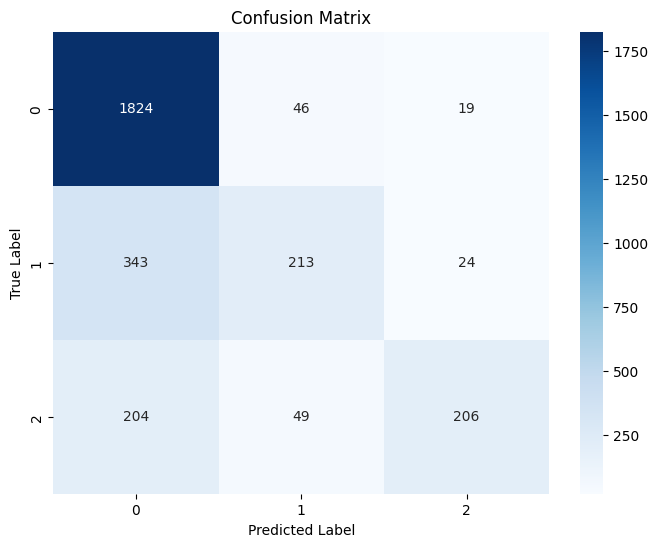

In [31]:
# Entrenar el modelo con los datos de entrenamiento
rf_model_1.fit(x_train, y_train)

# Predicciones en el conjunto de entrenamiento
y_train_pred = rf_model_1.predict(x_train)

# Predicciones en el conjunto de prueba
y_test_pred = rf_model_1.predict(x_test)

# Cálculo de métricas en el conjunto de entrenamiento (Multiclase)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Cálculo de métricas en el conjunto de prueba (Multiclase)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Mostrar las métricas para el conjunto de entrenamiento
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")

# Mostrar las métricas para el conjunto de prueba
print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Graficar la matriz de confusión para el conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Exercise 1.4

Predict the sentiment using TfidfVectorizer.

use Random Forest classifier

In [32]:
tfidf = TfidfVectorizer()
rep_tfidf = tfidf.fit_transform(X).toarray()
rep_tfidf.shape

(14640, 15740)

In [33]:
x_train, x_test, y_train, y_test = (train_test_split (rep_tfidf, y, test_size=0.2, random_state=42))
print(x_train.shape)
print(x_test.shape)

(11712, 15740)
(2928, 15740)


In [34]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Training Metrics:
Accuracy: 0.9978
Precision: 0.9978
Recall: 0.9978
F1-Score: 0.9978

Testing Metrics:
Accuracy: 0.7637
Precision: 0.7642
Recall: 0.7637
F1-Score: 0.7346


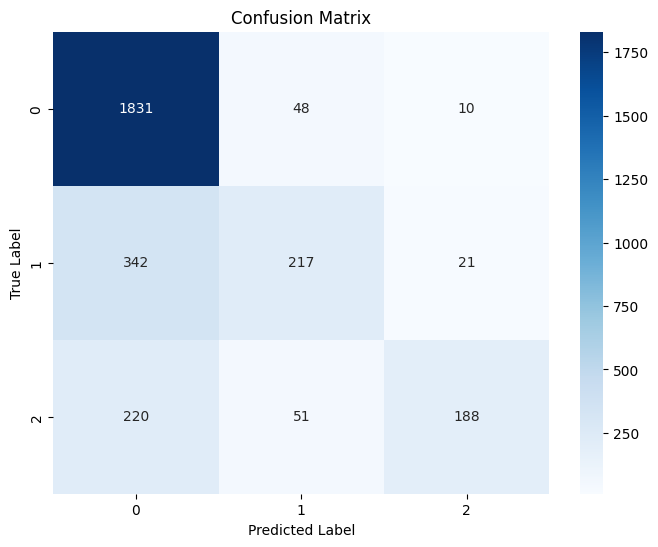

In [35]:
# Entrenar el modelo con los datos de entrenamiento
rf_model_1.fit(x_train, y_train)

# Predicciones en el conjunto de entrenamiento
y_train_pred = rf_model_1.predict(x_train)

# Predicciones en el conjunto de prueba
y_test_pred = rf_model_1.predict(x_test)

# Cálculo de métricas en el conjunto de entrenamiento (Multiclase)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Cálculo de métricas en el conjunto de prueba (Multiclase)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Mostrar las métricas para el conjunto de entrenamiento
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")

# Mostrar las métricas para el conjunto de prueba
print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Graficar la matriz de confusión para el conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [36]:
tfidf_2 = TfidfVectorizer(ngram_range=(1, 3), stop_words="english")
rep_tfidf_2 = tfidf_2.fit_transform(X).toarray()
rep_tfidf_2.shape

(14640, 202516)

In [37]:
x_train, x_test, y_train, y_test = (train_test_split (rep_tfidf_2, y, test_size=0.2, random_state=42))
print(x_train.shape)
print(x_test.shape)

(11712, 202516)
(2928, 202516)


In [38]:
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

Training Metrics:
Accuracy: 0.9958
Precision: 0.9958
Recall: 0.9958
F1-Score: 0.9958

Testing Metrics:
Accuracy: 0.7459
Precision: 0.7332
Recall: 0.7459
F1-Score: 0.7116


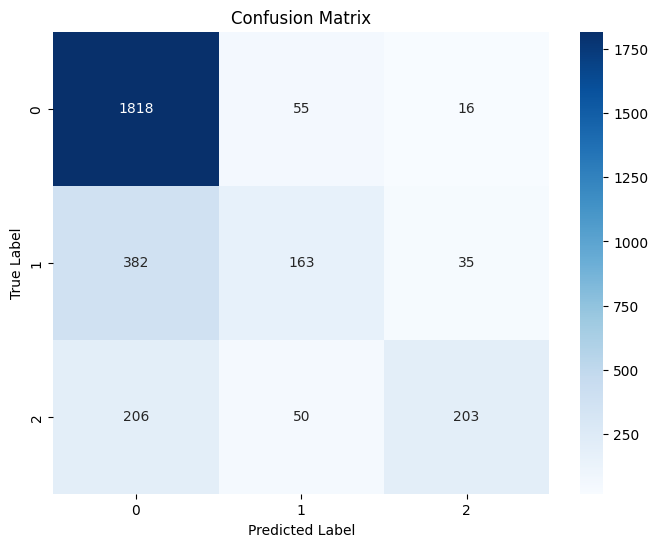

In [39]:
# Entrenar el modelo con los datos de entrenamiento
rf_model_1.fit(x_train, y_train)

# Predicciones en el conjunto de entrenamiento
y_train_pred = rf_model_1.predict(x_train)

# Predicciones en el conjunto de prueba
y_test_pred = rf_model_1.predict(x_test)

# Cálculo de métricas en el conjunto de entrenamiento (Multiclase)
train_accuracy = accuracy_score(y_train, y_train_pred)
train_precision = precision_score(y_train, y_train_pred, average='weighted')
train_recall = recall_score(y_train, y_train_pred, average='weighted')
train_f1 = f1_score(y_train, y_train_pred, average='weighted')

# Cálculo de métricas en el conjunto de prueba (Multiclase)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_precision = precision_score(y_test, y_test_pred, average='weighted')
test_recall = recall_score(y_test, y_test_pred, average='weighted')
test_f1 = f1_score(y_test, y_test_pred, average='weighted')

# Mostrar las métricas para el conjunto de entrenamiento
print("Training Metrics:")
print(f"Accuracy: {train_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall: {train_recall:.4f}")
print(f"F1-Score: {train_f1:.4f}")

# Mostrar las métricas para el conjunto de prueba
print("\nTesting Metrics:")
print(f"Accuracy: {test_accuracy:.4f}")
print(f"Precision: {test_precision:.4f}")
print(f"Recall: {test_recall:.4f}")
print(f"F1-Score: {test_f1:.4f}")

# Graficar la matriz de confusión para el conjunto de prueba
conf_matrix = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()